In [5]:
import functools
import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [6]:
# Change parameters if necessary
results_folder = "results"
model_names = ["twitter", "financial", "english"]
sarcasm_indices_file = "sarcasm_indices.txt"

# Setup

In [7]:
data = pd.read_csv("sampled_data.csv", index_col=0)

In [8]:
def extract_id(path):
    parts = Path(path).stem.split("_")
    return int(parts[1])

results = {}
for model_name in model_names:
    files = glob.glob(f"{results_folder}/{model_name}_*_results.csv")
    dfs = [(extract_id(path), pd.read_csv(path, index_col=0)) for path in files]
    sorted_dfs = sorted(dfs, key=lambda x: x[0])
    results[model_name] = pd.concat([df for id, df in sorted_dfs])
    results[model_name].index = data.index
results["english"]["neutral"] = 0

In [9]:
with open(sarcasm_indices_file) as f:
    sarcasm_indices = [int(line.rstrip()) for line in f.readlines()]
sarcasm_data = data.iloc[sarcasm_indices]
sarcasm_results = {name : df.iloc[sarcasm_indices] for name, df in results.items()}
data["is_sarcasm"] = data.index.isin(sarcasm_indices)

# Evaluate Results

## Approach 1
We compare positive/negative predictions, and treat neutral classifications always as false-classifications.

In [10]:
def neutral_false_accuracy(df, data=data):
    predicted_label = df[["negative", "positive", "neutral"]].idxmax(axis=1)
    prediction = predicted_label.map({"negative": -1, "positive": 1, "neutral": 0})
    return (prediction == data["review_score"]).mean()

for name, df in results.items():
    acc = neutral_false_accuracy(df)
    print(f"Accuracy for '{name}' is {acc}")

Accuracy for 'twitter' is 0.62931
Accuracy for 'financial' is 0.36794
Accuracy for 'english' is 0.85981


## Approach 2
We skip the rows that are classified as 'neutral', by any model. Meaning we will work on much less data than before.

In [11]:
def skip_neutral_accuracy(df):
    def comp_neutral_mask(df):
        predicted_label = df[["negative", "positive", "neutral"]].idxmax(axis=1)
        return predicted_label == "neutral"
    neutral_masks = [comp_neutral_mask(df) for df in results.values()]
    full_neutral_mask = functools.reduce(lambda df1, df2: df1 | df2, neutral_masks)
    
    filtered_df = df[~full_neutral_mask]
    filtered_data = data[~full_neutral_mask]
    predicted_label = filtered_df[["negative", "positive", "neutral"]].idxmax(axis=1)
    prediction = predicted_label.map({"negative": -1, "positive": 1})
    return (prediction == filtered_data["review_score"]).mean()

for name, df in results.items():
    acc = skip_neutral_accuracy(df)
    print(f"Accuracy for '{name}' is {acc}")

Accuracy for 'twitter' is 0.8665924065032943
Accuracy for 'financial' is 0.8398113475849647
Accuracy for 'english' is 0.8952694695928332


## Approach 3
We ignore the neutral predictions, and just take the highest value accross negative and positive scores.

In [12]:
def highest_posneg_accuracy(df, data=data):
    predicted_label = df[["negative", "positive"]].idxmax(axis=1)
    prediction = predicted_label.map({"negative": -1, "positive": 1})
    return (prediction == data["review_score"]).mean()

for name, df in results.items():
    acc = highest_posneg_accuracy(df)
    print(f"Accuracy for '{name}' is {acc}")

Accuracy for 'twitter' is 0.72408
Accuracy for 'financial' is 0.78577
Accuracy for 'english' is 0.85981


# Evaluate sarcasm results

## Approach 1

In [13]:
for name, df in sarcasm_results.items():
    acc = neutral_false_accuracy(df, data=sarcasm_data)
    print(f"Accuracy for '{name}' is {acc}")

Accuracy for 'twitter' is 0.3125
Accuracy for 'financial' is 0.11805555555555555
Accuracy for 'english' is 0.5694444444444444


## Approach 3

In [14]:
for name, df in sarcasm_results.items():
    acc = highest_posneg_accuracy(df, data=sarcasm_data)
    print(f"Accuracy for '{name}' is {acc}")

Accuracy for 'twitter' is 0.4027777777777778
Accuracy for 'financial' is 0.4375
Accuracy for 'english' is 0.5694444444444444


# Polarity Histograms
For each prediction we compute a polarity score between -1 and 1, indicating if the model thinks the text is negative or positive. Since each model outputs a softmax for either \[negative, positive\] or \[negative, neutral, positive\], we can treat them as probabilities to compute the expected polarity.

In [15]:
# Approach 1
def expected_polarity(df):
    # We can ignore df["neutral"] since it would be just df["neutral"] * 0.
    # This also saves us the effort of having to check if that column even exists
    return -1 * df["negative"] + 1 * df["positive"]

# Approach 3
def expected_polarity_no_neutral(df):
    neg_pos_sum = df["negative"] + df["positive"]
    return -1 * (df["negative"] / neg_pos_sum) + 1 * (df["positive"] / neg_pos_sum)

def create_violinplot(data_dict):
    fig = plt.figure(figsize=(15, 8))
    ax = sns.violinplot(fig=fig, data=[v for v in data_dict.values()], cut=0)
    sns.despine(left=True)
    ax.set_xticklabels([name for name in sarcasm_results.keys()])
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray')
    ax.set_ylabel("Residuals", size=20)
    return fig, ax

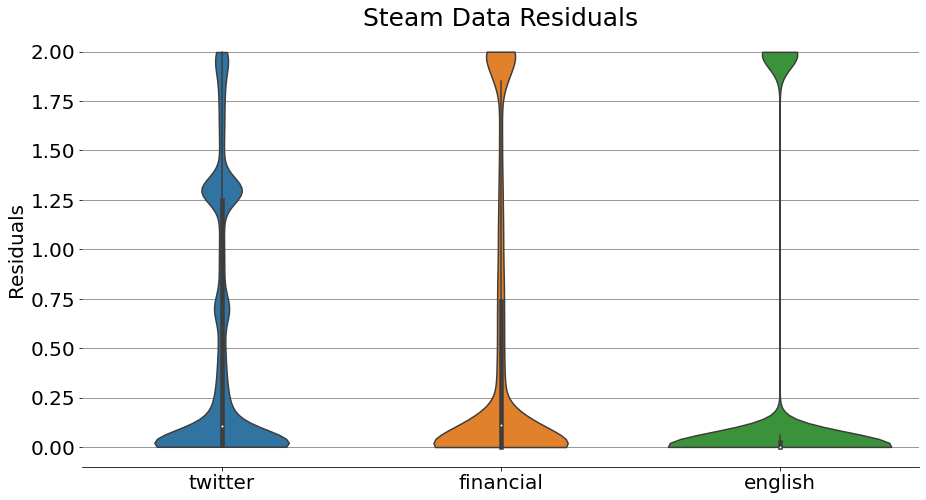

In [16]:
all_residuals = {}
for name, df in results.items():
    res = expected_polarity_no_neutral(df)
    residuals = data["review_score"] - res
    all_residuals[name] = abs(residuals)
    
fig, ax = create_violinplot(all_residuals)
ax.set_title("Steam Data Residuals", size=25)
fig.savefig("strategy3_residuals_violin.png", bbox_inches='tight')

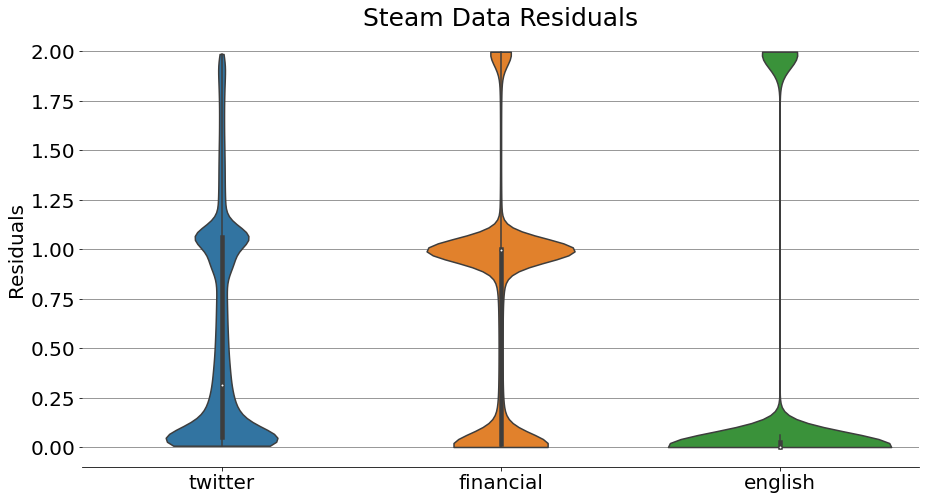

In [20]:
all_residuals = {}
for name, df in results.items():
    res = expected_polarity(df)
    residuals = data["review_score"] - res
    all_residuals[name] = abs(residuals)
    
fig, ax = create_violinplot(all_residuals)
ax.set_title("Steam Data Residuals", size=25)
fig.savefig("strategy1_residuals_violin.png", bbox_inches='tight')

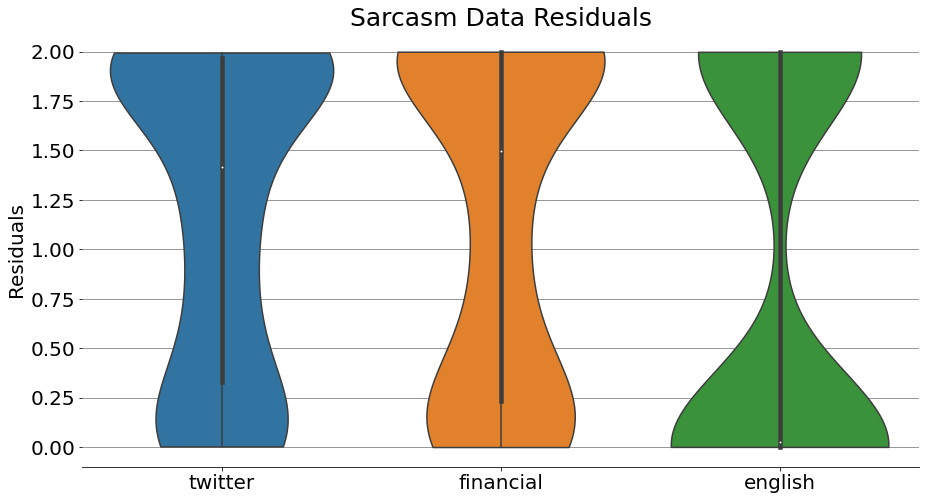

In [21]:
all_residuals = {}
for name, df in sarcasm_results.items():
    res = expected_polarity_no_neutral(df)
    residuals = sarcasm_data["review_score"] - res
    all_residuals[name] = abs(residuals)
    
fig, ax = create_violinplot(all_residuals)
ax.set_title("Sarcasm Data Residuals", size=25)
fig.savefig("strategy3_sarcasm_residuals_violin.png", bbox_inches='tight')

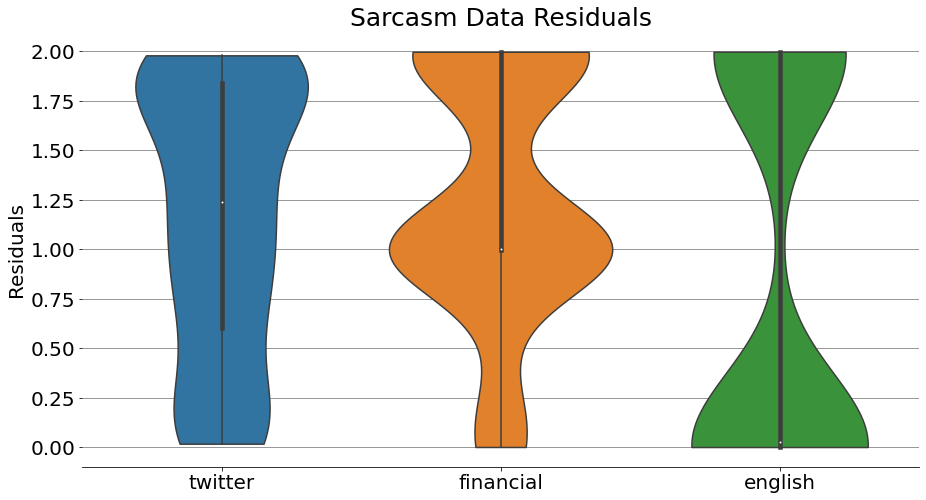

In [19]:
all_residuals = {}
for name, df in sarcasm_results.items():
    res = expected_polarity(df)
    residuals = sarcasm_data["review_score"] - res
    all_residuals[name] = abs(residuals)
    
fig, ax = create_violinplot(all_residuals)
ax.set_title("Sarcasm Data Residuals", size=25)
fig.savefig("strategy1_sarcasm_residuals_violin.png", bbox_inches='tight')